# Model Troll Tweets

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import HiveContext
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StopWordsRemover

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
spark = SparkSession.builder.appName('rus_trolls').getOrCreate()

# Change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '8g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

# Print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '50044'),
 ('spark.driver.memory', '4g'),
 ('spark.executor.id', 'driver'),
 ('spark.app.id', 'local-1552353528363'),
 ('spark.executor.cores', '4'),
 ('spark.cores.max', '4'),
 ('spark.app.name', 'Spark Updated Conf'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.memory', '8g'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '10.150.190.82'),
 ('spark.ui.showConsoleProgress', 'true')]

In [4]:
sc = spark.sparkContext
# hc = HiveContext(sc)

# Read data

In [5]:
# hive_context = HiveContext(sc)
# df = hive_context.table("tywang.trolls_non_trolls")
# df.show(10)

In [6]:
df = spark.read.csv('data/trolls_non_trolls.csv', inferSchema=True, header=False)

In [7]:
df.show()

+-----+--------------------+
|  _c0|                 _c1|
+-----+--------------------+
|troll|RT @RappersIQ: #P...|
|troll|RT @BlackNewsOutl...|
|troll|RT @Herobright2: ...|
|troll|Mexico City metro...|
|troll|And will replace ...|
|troll|#morningjoe  If y...|
|troll| Have a nice Tuesday|
|troll|RT @2a43e23eca444...|
|troll|I've noticed that...|
|troll|https://t.co/zXPH...|
|troll|*= Lunch breaks a...|
|troll|Judge Mike Erwin ...|
|troll|RT @UraniumTesfai...|
|troll|RT @CarlaChamorro...|
|troll|You wanna count m...|
|troll|#local Free sprin...|
|troll|FORECAST | Cooler...|
|troll|Comment here on h...|
|troll|3 arrested in con...|
|troll|Horror director W...|
+-----+--------------------+
only showing top 20 rows



In [8]:
oldColumns = df.schema.names
newColumns = ["class", "tweet_text"]

for i in range(0, len(oldColumns)):
    df = df.withColumnRenamed(oldColumns[i], newColumns[i])

In [9]:
df.groupBy("class").count().show()

+--------+-------+
|   class|  count|
+--------+-------+
|   troll|1358472|
|innocent|1600000|
+--------+-------+



In [10]:
df.dropna().groupBy("class").count().show()

+--------+-------+
|   class|  count|
+--------+-------+
|   troll|1358460|
|innocent|1599960|
+--------+-------+



In [11]:
is_troll = df.select("class").rdd.flatMap(lambda x: 1 if x =='troll' else 0)

In [12]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf

def modify_values(r):
    if r == "troll":
        return 1
    else:
        return 0
ol_val = udf(modify_values, IntegerType())
df = df.withColumn("class", ol_val(df["class"]))

In [13]:
df.dropna().groupBy("class").count().show()

+-----+-------+
|class|  count|
+-----+-------+
|    1|1358460|
|    0|1599960|
+-----+-------+



In [14]:
df = df.dropna()

# Transform data

In [15]:
tokenizer = Tokenizer(inputCol="tweet_text", outputCol="words")
df_words = tokenizer.transform(df)
df_words = df_words.drop("tweet_text")
df_words.show(5)

+-----+--------------------+
|class|               words|
+-----+--------------------+
|    1|[rt, @rappersiq:,...|
|    1|[rt, @blacknewsou...|
|    1|[rt, @herobright2...|
|    1|[mexico, city, me...|
|    1|[and, will, repla...|
+-----+--------------------+
only showing top 5 rows



In [16]:
# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_content")
df_words_removed_sw = remover.transform(df_words)

# Drop the redundant source column
df_words_removed_sw = df_words_removed_sw.drop("words")
df_words_removed_sw.show(5)

+-----+--------------------+
|class|    filtered_content|
+-----+--------------------+
|    1|[rt, @rappersiq:,...|
|    1|[rt, @blacknewsou...|
|    1|[rt, @herobright2...|
|    1|[mexico, city, me...|
|    1|[replace, "magist...|
+-----+--------------------+
only showing top 5 rows



In [17]:
hashingTF = HashingTF(inputCol="filtered_content", outputCol="rawFeatures", numFeatures=20)
featurizedData = hashingTF.transform(df_words_removed_sw)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
nlpdf = idfModel.transform(featurizedData)
nlpdf.select("class", "features").show(10)

+-----+--------------------+
|class|            features|
+-----+--------------------+
|    1|(20,[0,1,5,6,7,8,...|
|    1|(20,[2,6,8,11,13]...|
|    1|(20,[2,4,5,7,9,13...|
|    1|(20,[5,6,7,11,14,...|
|    1|(20,[7,13,19],[1....|
|    1|(20,[8,9,12,19],[...|
|    1|(20,[1,10],[1.424...|
|    1|(20,[0,4,7,10,11,...|
|    1|(20,[1,4,6,13,14,...|
|    1|(20,[3,9],[1.4278...|
+-----+--------------------+
only showing top 10 rows



In [18]:
# # Learn a mapping from words to Vectors
# from pyspark.ml.feature import Word2Vec
# word2Vec = Word2Vec(vectorSize=5, minCount=0, inputCol="filtered_content", outputCol="wordVectors")
# w2VM = word2Vec.fit(df_words_removed_sw)
# nlpdf = w2VM.transform(df_words_removed_sw)

In [19]:
# Split data into train and test
splits = nlpdf.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

train_df.show(1)

+-----+----------------+-----------+----------+
|class|filtered_content|rawFeatures|  features|
+-----+----------------+-----------+----------+
|    1|              []| (20,[],[])|(20,[],[])|
+-----+----------------+-----------+----------+
only showing top 1 row



In [20]:
# Set parameters for Logistic Regression
from pyspark.ml.classification import LogisticRegression

lgr = LogisticRegression(maxIter=10, featuresCol="features", labelCol="class")

# Fit the model to the data.
lgrm = lgr.fit(train_df)

# Given a dataset, predict each point's label, and show the results.
predictions = lgrm.transform(test_df)

In [21]:
# print evaluation metrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction")

print(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

0.6798981344949337
0.6762354161673665


In [23]:
lgrm.summary.roc.select('FPR').collect()
lgrm.summary.roc.select('TPR').collect()

[Row(TPR=0.0),
 Row(TPR=0.011301747553526243),
 Row(TPR=0.023023849842297987),
 Row(TPR=0.03353455785028565),
 Row(TPR=0.043870501307514784),
 Row(TPR=0.0556781462448157),
 Row(TPR=0.06823451931010314),
 Row(TPR=0.08113030352923213),
 Row(TPR=0.09414014461306669),
 Row(TPR=0.10683632931896095),
 Row(TPR=0.1191103196627596),
 Row(TPR=0.13057763363279393),
 Row(TPR=0.14132657331786821),
 Row(TPR=0.15154018158956636),
 Row(TPR=0.1610354155763045),
 Row(TPR=0.17030345564705654),
 Row(TPR=0.17843460632445315),
 Row(TPR=0.1877440379993322),
 Row(TPR=0.19785370735400032),
 Row(TPR=0.20894573744661632),
 Row(TPR=0.2212712373422175),
 Row(TPR=0.23424428588905027),
 Row(TPR=0.24778945838626093),
 Row(TPR=0.261445008494477),
 Row(TPR=0.2756377296429192),
 Row(TPR=0.2899537057903175),
 Row(TPR=0.3040001766041776),
 Row(TPR=0.3718226194998607),
 Row(TPR=0.3858396562841193),
 Row(TPR=0.39981438165082595),
 Row(TPR=0.4133282804915851),
 Row(TPR=0.4265174851933034),
 Row(TPR=0.43969565213392114),
 Row

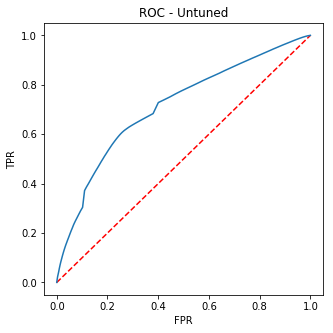

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lgrm.summary.roc.select('FPR').collect(),
         lgrm.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC - Untuned")
plt.savefig('roc_untuned.png')
plt.show()
